# **VFM (Θ_H фиксированы)**

In [ ]:
import numpy as np
from scipy.special import expit

d = 4
r = 3
n = 500
M = 100

# Фиксированные гиперпараметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

batch_size = 500
lr = 0.001

errors = []
for m in range(M):
    X = np.random.randn(n, d)
    # Параметры
    w_0 = np.random.normal(mu_w_0, np.sqrt(1/lambda_w_0))
    lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
    mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
    w = np.random.normal(mu_w, np.sqrt(1/lambda_w), d)
    lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
    mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)
    v = np.random.normal(mu_v, np.sqrt(1/lambda_v), (d, r))

    # Beta_teor
    Beta_teor = np.concatenate((np.array([w_0]), w, v.flatten(), np.array([lambda_w, mu_w]), lambda_v, mu_v))
    Beta_teor = Beta_teor[np.newaxis, :]

    double_Sum_teor = 0.5 * np.sum((X @ v)**2 - (X**2) @ (v**2), axis=1)
    p = expit(w_0 + X @ w + double_Sum_teor)
    y = np.random.binomial(1, p, n).astype(np.float64)

    # Вариационные параметры
    mu_w0_new = 0.0
    sigma_w0_new = 0.1

    mu_w_new = np.zeros(d)
    sigma_w_new = np.ones(d)

    mu_v_new = np.zeros((d, r))
    sigma_v_new = np.ones((d, r))

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        X_batch = X[start:end]
        y_batch = y[start:end]

        epsilon_w0 = np.random.normal(0, 1)
        epsilon_w = np.random.normal(0, 1, d)
        epsilon_v = np.random.normal(0, 1, (d, r))

        Theta_0 = mu_w0_new + epsilon_w0 * sigma_w0_new
        Theta_w = mu_w_new + epsilon_w * sigma_w_new
        Theta_v = mu_v_new + epsilon_v * sigma_v_new

        F_B = np.where(np.any(X_batch != 0, axis=0))[0]
        N_k = np.sum(X[:, F_B] != 0, axis=0)
        N_B_k = np.sum(X_batch[:, F_B] != 0, axis=0)

        alpha_k = N_B_k / N_k

        grad_mu_w0 = (n / batch_size) * np.sum(y_batch - expit(Theta_0 + X_batch @ Theta_w +
                      0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) \
                        - d / np.sum(alpha_k) * np.sum(alpha_k * (mu_w0_new - mu_w_0) / (1/lambda_w_0))

        grad_sigma_w0 = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                        0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * epsilon_w0) \
                          - d / np.sum(alpha_k) * np.sum(alpha_k * (sigma_w0_new / (1/lambda_w_0) - 1 / sigma_w0_new))

        grad_mu_w = np.zeros(d)
        grad_sigma_w = np.zeros(d)
        grad_mu_v = np.zeros((d, r))
        grad_sigma_v = np.zeros((d, r))

        for k in F_B:
            grad_mu_w[k] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                    0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * X_batch[:, k]) \
                    - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (mu_w_new[k] - mu_w) / (1/lambda_w))


            grad_sigma_w[k] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                      0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * X_batch[:, k] * epsilon_w[k])\
                      - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (sigma_w_new[k] / (1/lambda_w) - 1 / sigma_w_new[k]))

        for f in range(r):
            for k in F_B:
                grad_mu_v[k, f] = ((n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                          0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) *
                          (X_batch[:, k] * (X_batch @ Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k]**2))
                            - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (mu_v_new[k, f] - mu_v[f]) / (1/lambda_v[f])))


                grad_sigma_v[k, f] = ((n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                          0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * epsilon_v[k, f] *
                            (X_batch[:, k] * (X_batch @ Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k]**2))
                            - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (sigma_v_new[k, f] / (1/lambda_v[f]) - 1 / sigma_v_new[k, f])))

        mu_w0_new += lr * grad_mu_w0
        sigma_w0_new += lr * grad_sigma_w0

        mu_w_new[F_B] += lr * grad_mu_w[F_B]
        sigma_w_new[F_B] += lr * grad_sigma_w[F_B]

        mu_v_new[F_B] += lr * grad_mu_v[F_B]
        sigma_v_new[F_B] += lr * grad_sigma_v[F_B]

    error = np.sqrt(np.sum((w -mu_w_new)**2))
    errors.append(error)

print("Средняя ошибка:", np.mean(errors))


Средняя ошибка: 4.452002473571216


In [ ]:
import numpy as np
from scipy.special import expit

d = 4
r = 3
n = 500
M = 100

# Фиксированные гиперпараметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

batch_size = 500
lr = 0.001

errors = []
for m in range(M):
    X = np.random.randn(n, d)
    # Параметры
    w_0 = np.random.normal(mu_w_0, np.sqrt(1/lambda_w_0))
    lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
    mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
    w = np.random.normal(mu_w, np.sqrt(1/lambda_w), d)
    lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
    mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)
    v = np.random.normal(mu_v, np.sqrt(1/lambda_v), (d, r))

    # Beta_teor
    Beta_teor = np.concatenate((np.array([w_0]), w, v.flatten(), np.array([lambda_w, mu_w]), lambda_v, mu_v))
    Beta_teor = Beta_teor[np.newaxis, :]

    double_Sum_teor = 0.5 * np.sum((X @ v)**2 - (X**2) @ (v**2), axis=1)
    p = expit(w_0 + X @ w + double_Sum_teor)
    y = np.random.binomial(1, p, n).astype(np.float64)

    # Вариационные параметры
    mu_w0_new = 0.0
    sigma_w0_new = 0.1

    mu_w_new = np.zeros(d)
    sigma_w_new = np.ones(d)

    mu_v_new = np.zeros((d, r))
    sigma_v_new = np.ones((d, r))

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        X_batch = X[start:end]
        y_batch = y[start:end]

        epsilon_w0 = np.random.normal(0, 1)
        epsilon_w = np.random.normal(0, 1, d)
        epsilon_v = np.random.normal(0, 1, (d, r))

        Theta_0 = mu_w0_new + epsilon_w0 * sigma_w0_new
        Theta_w = mu_w_new + epsilon_w * sigma_w_new
        Theta_v = mu_v_new + epsilon_v * sigma_v_new

        F_B = np.where(np.any(X_batch != 0, axis=0))[0]
        N_k = np.sum(X[:, F_B] != 0, axis=0)
        N_B_k = np.sum(X_batch[:, F_B] != 0, axis=0)

        alpha_k = N_B_k / N_k

        grad_mu_w0 = (n / batch_size) * np.sum(y_batch - expit(Theta_0 + X_batch @ Theta_w +
                      0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) \
                        - d / np.sum(alpha_k) * np.sum(alpha_k * (mu_w0_new - mu_w_0) / (1/lambda_w_0))

        grad_sigma_w0 = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                        0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * epsilon_w0) \
                          - d / np.sum(alpha_k) * np.sum(alpha_k * (sigma_w0_new / (1/lambda_w_0) - 1 / sigma_w0_new))

        grad_mu_w = np.zeros(d)
        grad_sigma_w = np.zeros(d)
        grad_mu_v = np.zeros((d, r))
        grad_sigma_v = np.zeros((d, r))

        for idx, k in enumerate(F_B):
                grad_mu_w[k] = (n/ batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +0.5 * np.sum((X_batch @ Theta_v) ** 2 - (X_batch ** 2) @ (Theta_v ** 2), axis=1))) * X_batch[:, k]) \
                                - (d / np.sum(alpha_k)) * (alpha_k[idx] * (mu_w_new[k] - mu_w) / (1/lambda_w))

                grad_sigma_w[k] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +0.5 * np.sum((X_batch @ Theta_v) ** 2 - (X_batch ** 2) @ (Theta_v ** 2), axis=1))) * X_batch[:, k] * epsilon_w[k]) \
                                  - (d / np.sum(alpha_k)) * (alpha_k[idx] * (sigma_w_new[k] / (1/lambda_w) - 1 / sigma_w_new[k]))

        for f in range(r):
            for idx, k in enumerate(F_B):
                grad_mu_v[k, f] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +0.5 * np.sum((X_batch @ Theta_v) ** 2 - (X_batch ** 2) @ (Theta_v ** 2), axis=1))) *
                            (X_batch[:, k] * (X_batch @ Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k] ** 2)) \
                            - (d / np.sum(alpha_k)) * (alpha_k[idx] * (mu_v_new[k, f] - mu_v[f]) / (1/lambda_v[f]))

                grad_sigma_v[k, f] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +0.5 * np.sum((X_batch @ Theta_v) ** 2 - (X_batch ** 2) @ (Theta_v ** 2), axis=1))) * epsilon_v[k, f] *
                            (X_batch[:, k] * (X_batch @ Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k] ** 2)) \
                            - (d / np.sum(alpha_k)) * (alpha_k[idx] * (sigma_v_new[k, f] / (1/lambda_v[f]) - 1 / sigma_v_new[k, f]))

        mu_w0_new += lr * grad_mu_w0
        sigma_w0_new += lr * grad_sigma_w0

        mu_w_new[F_B] += lr * grad_mu_w[F_B]
        sigma_w_new[F_B] += lr * grad_sigma_w[F_B]

        mu_v_new[F_B] += lr * grad_mu_v[F_B]
        sigma_v_new[F_B] += lr * grad_sigma_v[F_B]

    error = np.sqrt(np.sum((w -mu_w_new)**2))
    errors.append(error)

print("Средняя ошибка:", np.mean(errors))

Средняя ошибка: 4.7730089709678545


# Новый раздел

Выходные данные были обрезаны до нескольких последних строк (5000).
 [ 0.15003328  0.16908853 -0.3344421 ]
 [ 0.17944403  0.03319822 -0.21903455]
 [ 0.48784606 -0.04556803 -0.24832559]]
[[1.19643547 0.67919171 1.40460042]
 [1.21838758 0.5143984  0.76576426]
 [0.98887388 0.68523445 0.83655659]
 [1.08267755 0.57133117 0.84817195]]
[[ 0.10649634 -0.15161223 -0.0699328 ]
 [ 0.16339901  0.1913889  -0.38533366]
 [ 0.13969437 -0.03613983 -0.19765291]
 [ 0.56137321 -0.01097431 -0.27167914]]
[[1.20467248 0.64454378 1.4466047 ]
 [1.27162136 0.47132681 0.7097507 ]
 [0.94045475 0.64877469 0.87779806]
 [1.02213721 0.53635551 0.79495036]]
[[ 0.14239571 -0.19916264 -0.11455064]
 [ 0.20786892  0.20115903 -0.44632793]
 [ 0.1359204  -0.04736442 -0.14472787]
 [ 0.63872301  0.01705262 -0.22923009]]
[[1.25374388 0.61268185 1.40558901]
 [1.31911532 0.43601653 0.64155678]
 [0.9656993  0.66002306 0.84763252]
 [0.97210961 0.50818292 0.73319281]]
[[ 0.19179864 -0.23510973 -0.15411723]
 [ 0.26867983  0.23174203 

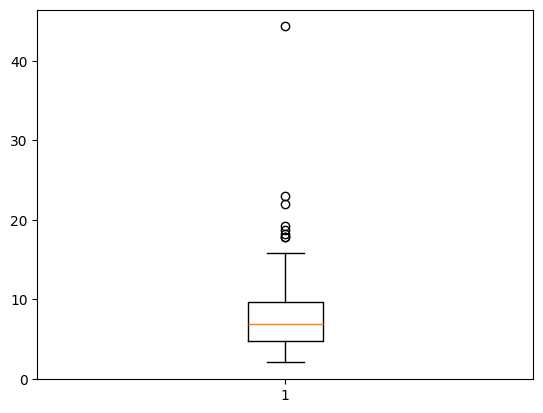

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from scipy.special import expit

tfd = tfp.distributions

d = 4
r = 3
n = 500
M = 100

# Фиксированные гиперпараметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

batch_size = 50
lr = 0.1

errors = []
for m in range(M):
    X = np.random.randn(n, d)
    # Параметры
    w_0 = np.random.normal(mu_w_0, np.sqrt(1/lambda_w_0))
    lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
    mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
    w = np.random.normal(mu_w, np.sqrt(1/lambda_w), d)
    lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
    mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)
    v = np.random.normal(mu_v, np.sqrt(1/lambda_v), (d, r))

    # Beta_teor
    Beta_teor = np.concatenate((np.array([w_0]), w, v.flatten(), np.array([lambda_w, mu_w]), lambda_v, mu_v))
    Beta_teor = Beta_teor[np.newaxis, :]

    double_Sum_teor = 0.5 * np.sum((X.dot(v))**2 - (X**2).dot(v**2), axis=1)
    p = expit(w_0 + X.dot(w) + double_Sum_teor)
    y = np.random.binomial(1, p, n).astype(np.float64)

    mu_w0_new = tf.Variable(0.0, dtype=tf.float64)
    sigma_w0_new = tf.Variable(0.1, dtype=tf.float64)

    mu_w_new = tf.Variable(np.zeros(d), dtype=tf.float64)
    sigma_w_new = tf.Variable(np.ones(d), dtype=tf.float64)

    mu_v_new = tf.Variable(np.zeros((d, r)), dtype=tf.float64)
    sigma_v_new = tf.Variable(np.ones((d, r)), dtype=tf.float64)


    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        X_batch = X[start:end]
        y_batch = y[start:end]

        F_B = np.where(np.any(X_batch != 0, axis=0))[0]

        N_k = np.sum(X[:, F_B], axis=0)
        N_B_k = np.sum(X_batch[:, F_B], axis=0)

        alpha_k = N_B_k / N_k

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(mu_w0_new)
            tape.watch(sigma_w0_new)
            tape.watch(mu_w_new)
            tape.watch(sigma_w_new)
            tape.watch(mu_v_new)
            tape.watch(sigma_v_new)

            epsilon_w0 = np.random.normal(0, 1)
            epsilon_w = np.random.normal(0, 1, d)
            epsilon_v = np.random.normal(0, 1, (d, r))

            Theta_0 = mu_w0_new + epsilon_w0 * sigma_w0_new
            Theta_w = mu_w_new + epsilon_w * sigma_w_new
            Theta_v = mu_v_new + epsilon_v * sigma_v_new

        grad_mu_w0 = (n / batch_size) * tf.reduce_sum(y_batch - expit(Theta_0 + X_batch.dot(Theta_w) +
                              0.5 * tf.reduce_sum((X_batch.dot(Theta_v)) ** 2 - (X_batch ** 2).dot(Theta_v ** 2), axis=1))) \
                            - d / tf.reduce_sum(alpha_k) * tf.reduce_sum(alpha_k * (mu_w0_new - mu_w_0) / (1/lambda_w_0))
        grad_sigma_w0 = (n / batch_size) * tf.reduce_sum((y_batch - expit(Theta_0 + X_batch.dot(Theta_w) +
                            0.5 * tf.reduce_sum((X_batch.dot(Theta_v)) ** 2 - (X_batch ** 2).dot(Theta_v ** 2), axis=1))) * epsilon_w0) \
                            - d / tf.reduce_sum(alpha_k) * tf.reduce_sum(alpha_k * (sigma_w0_new / (1/lambda_w_0) - 1 / sigma_w0_new))

        grad_mu_w = np.zeros(len(F_B), dtype=np.float64)
        grad_sigma_w = np.zeros(len(F_B), dtype=np.float64)
        grad_mu_v = np.zeros((len(F_B), r), dtype=np.float64)
        grad_sigma_v = np.zeros((len(F_B), r), dtype=np.float64)

        for k in F_B:
            grad_mu_w[k] = (n / batch_size) * tf.reduce_sum((y_batch - expit(Theta_0 + X_batch.dot(Theta_w) +
                    0.5 * tf.reduce_sum((X_batch.dot(Theta_v)) ** 2 - (X_batch ** 2).dot(Theta_v ** 2), axis=1))) * X_batch[:, k]) \
                    - (d / tf.reduce_sum(alpha_k)) * tf.reduce_sum(alpha_k[k] * (mu_w_new[k] - mu_w) / (1/lambda_w))

            grad_sigma_w[k] = (n / batch_size) * tf.reduce_sum((y_batch - expit(Theta_0 + X_batch.dot(Theta_w) +
                      0.5 * tf.reduce_sum((X_batch.dot(Theta_v)) ** 2 - (X_batch ** 2).dot(Theta_v ** 2), axis=1))) * X_batch[:, k] * epsilon_w[k]) \
                      - (d / tf.reduce_sum(alpha_k)) * tf.reduce_sum(alpha_k[k] * (sigma_w_new[k] / (1/lambda_w) - 1 / sigma_w_new[k]))

        for f in range(r):
            for k in F_B:
                grad_mu_v[k, f] = ((n / batch_size) * tf.reduce_sum((y_batch - expit(Theta_0 + X_batch.dot(Theta_w) +
                              0.5 * tf.reduce_sum((X_batch.dot(Theta_v)) ** 2 - (X_batch ** 2).dot(Theta_v ** 2), axis=1))) *
                              (X_batch[:, k] * X_batch.dot(Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k]**2)) \
                              - (d / tf.reduce_sum(alpha_k)) * tf.reduce_sum(alpha_k[k] * (mu_v_new[k, f] - mu_v[f]) / (1/lambda_v[f])))

                grad_sigma_v[k, f] = ((n / batch_size) * tf.reduce_sum((y_batch - expit(Theta_0 + X_batch.dot(Theta_w) +
                              0.5 * tf.reduce_sum((X_batch.dot(Theta_v)) ** 2 - (X_batch ** 2).dot(Theta_v ** 2), axis=1))) * epsilon_v[k, f] *
                                (X_batch[:, k] * X_batch.dot(Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k]**2)) \
                                - (d / tf.reduce_sum(alpha_k)) * tf.reduce_sum(alpha_k[k] * (sigma_v_new[k, f] / (1/lambda_v[f]) - 1 / sigma_v_new[k, f])))

        optimizer.apply_gradients(zip([-grad_mu_w0, -grad_sigma_w0, -grad_mu_w, -grad_sigma_w, -grad_mu_v, -grad_sigma_v],
                                      [mu_w0_new, sigma_w0_new, mu_w_new, sigma_w_new, mu_v_new, sigma_v_new]))

        print(mu_v_new.numpy())
        print(sigma_v_new.numpy())

    error = np.sqrt(np.sum((v - mu_v_new.numpy())**2))
    errors.append(error)

print("Средняя ошибка:", np.mean(errors))

import matplotlib.pyplot as plt

plt.boxplot(errors)
plt.show()


# ДАТАСЕТ

**Pima Indians Diabetes Dataset**

In [ ]:
import pandas as pd
import numpy as np
from scipy.special import expit
from sklearn.metrics import roc_auc_score

data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv", header=None)
data_matrix = data.values

X = data_matrix[1:501, :8]
y = data_matrix[1:501, 8]
y = np.squeeze(y)

d = X.shape[1]

n = 500
r = 3

# Фиксированные гиперпараметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

batch_size = 50
lr = 0.00000001

errors = []
mu_w0_all = []
mu_w_all = []
mu_v_all = []

# Параметры
lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))

lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)

# lambda_w = 2
# mu_w = 3

# lambda_v = np.array([3, 2,5])
# mu_v = np.array([1,7,4])

# Вариационные параметры
mu_w0_new = 0.0
sigma_w0_new = 0.1

mu_w_new = np.zeros(d)
sigma_w_new = np.ones(d)

mu_v_new = np.zeros((d, r))
sigma_v_new = np.ones((d, r))

for start in range(0, n, batch_size):
    end = min(start + batch_size, n)
    X_batch = X[start:end]
    y_batch = y[start:end]

    epsilon_w0 = np.random.normal(0, 1)
    epsilon_w = np.random.normal(0, 1, d)
    epsilon_v = np.random.normal(0, 1, (d, r))

    Theta_0 = mu_w0_new + epsilon_w0 * sigma_w0_new
    Theta_w = mu_w_new + epsilon_w * sigma_w_new
    Theta_v = mu_v_new + epsilon_v * sigma_v_new

    F_B = np.where(np.any(X_batch != 0, axis=0))[0]
    N_k = np.sum(X[:, F_B] != 0, axis=0)
    N_B_k = np.sum(X_batch[:, F_B] != 0, axis=0)

    alpha_k = N_B_k / N_k

    grad_mu_w0 = (n / batch_size) * np.sum(y_batch - expit(Theta_0 + X_batch @ Theta_w +
                  0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) \
                    - d / np.sum(alpha_k) * np.sum(alpha_k * (mu_w0_new - mu_w_0) / (1/lambda_w_0))

    grad_sigma_w0 = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                    0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * epsilon_w0) \
                      - d / np.sum(alpha_k) * np.sum(alpha_k * (sigma_w0_new / (1/lambda_w_0) - 1 / sigma_w0_new))

    grad_mu_w = np.zeros(d)
    grad_sigma_w = np.zeros(d)
    grad_mu_v = np.zeros((d, r))
    grad_sigma_v = np.zeros((d, r))

    for k in F_B:
        grad_mu_w[k] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * X_batch[:, k]) \
                - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (mu_w_new[k] - mu_w) / (1/lambda_w))


        grad_sigma_w[k] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                  0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * X_batch[:, k] * epsilon_w[k])\
                  - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (sigma_w_new[k] / (1/lambda_w) - 1 / sigma_w_new[k]))

    for f in range(r):
        for k in F_B:
            grad_mu_v[k, f] = ((n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                      0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) *
                      (X_batch[:, k] * (X_batch @ Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k]**2))
                        - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (mu_v_new[k, f] - mu_v[f]) / (1/lambda_v[f])))


            grad_sigma_v[k, f] = ((n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                      0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * epsilon_v[k, f] *
                        (X_batch[:, k] * (X_batch @ Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k]**2))
                        - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (sigma_v_new[k, f] / (1/lambda_v[f]) - 1 / sigma_v_new[k, f])))

    mu_w0_new += lr * grad_mu_w0
    sigma_w0_new += lr * grad_sigma_w0

    mu_w_new[F_B] += lr * grad_mu_w[F_B]
    sigma_w_new[F_B] += lr * grad_sigma_w[F_B]

    mu_v_new[F_B] += lr * grad_mu_v[F_B]
    sigma_v_new[F_B] += lr * grad_sigma_v[F_B]

    mu_w0_all.append(mu_w0_new)
    mu_w_all.append(mu_w_new.copy())
    mu_v_all.append(mu_v_new.copy())

mu_w0_avg = np.mean(mu_w0_all, axis=0)
mu_w_avg = np.mean(mu_w_all, axis=0)
mu_v_avg = np.mean(mu_v_all, axis=0)

X1 = data_matrix[501:769, :8]
y1 = data_matrix[501:769, 8]

double_sum = 0.5 * (np.sum((X1 @ mu_v_avg )**2, axis=1) - (X1**2) @ np.sum(mu_v_avg**2, axis=1))

prob = expit(mu_w0_avg + X1 @ np.array(mu_w_avg)  + double_sum)
print(mu_v_avg)
# AUC-ROC
auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)



[[-0.00205039  0.00043677 -0.00134672]
 [-0.12395348 -0.09291974 -0.04284772]
 [-0.06218635 -0.0016213  -0.01897629]
 [-0.02774049 -0.00897757 -0.01302031]
 [-0.09454371 -0.04423442  0.00185372]
 [-0.03838605 -0.0100113  -0.0155595 ]
 [-0.00050308 -0.00012534 -0.00034987]
 [-0.03357397 -0.003097   -0.01052352]]
AUC-ROC: 0.5047539509186689


**Sonar Dataset**

In [ ]:
import numpy as np
from scipy.special import expit
import pandas as pd
from sklearn.metrics import roc_auc_score

data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", header=None)
ind = np.random.permutation(207)
data = data.iloc[ind]

n = 120
r = 2

data_new = data.iloc[:121, :]
X = data_new .iloc[1:, :60].values
y = (data_new .iloc[1:, 60] == 'R').astype(np.float64).values

d = X.shape[1]

# Фиксированные гиперпараметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

batch_size = 50
lr = 0.001

errors = []
mu_w0_all = []
mu_w_all = []
mu_v_all = []

# Параметры
lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)

# Вариационные параметры
mu_w0_new = 0.0
sigma_w0_new = 0.1

mu_w_new = np.zeros(d)
sigma_w_new = np.ones(d)

mu_v_new = np.zeros((d, r))
sigma_v_new = np.ones((d, r))


for start in range(0, n, batch_size):
    end = min(start + batch_size, n)
    X_batch = X[start:end]
    y_batch = y[start:end]

    epsilon_w0 = np.random.normal(0, 1)
    epsilon_w = np.random.normal(0, 1, d)
    epsilon_v = np.random.normal(0, 1, (d, r))

    Theta_0 = mu_w0_new + epsilon_w0 * sigma_w0_new
    Theta_w = mu_w_new + epsilon_w * sigma_w_new
    Theta_v = mu_v_new + epsilon_v * sigma_v_new

    F_B = np.where(np.any(X_batch != 0, axis=0))[0]
    N_k = np.sum(X[:, F_B] != 0, axis=0)
    N_B_k = np.sum(X_batch[:, F_B] != 0, axis=0)

    alpha_k = N_B_k / N_k

    grad_mu_w0 = (n / batch_size) * np.sum(y_batch - expit(Theta_0 + X_batch @ Theta_w +
                  0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) \
                    - d / np.sum(alpha_k) * np.sum(alpha_k * (mu_w0_new - mu_w_0) / (1/lambda_w_0))

    grad_sigma_w0 = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                    0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * epsilon_w0) \
                      - d / np.sum(alpha_k) * np.sum(alpha_k * (sigma_w0_new / (1/lambda_w_0) - 1 / sigma_w0_new))

    grad_mu_w = np.zeros(d)
    grad_sigma_w = np.zeros(d)
    grad_mu_v = np.zeros((d, r))
    grad_sigma_v = np.zeros((d, r))

    for k in F_B:
        grad_mu_w[k] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * X_batch[:, k]) \
                - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (mu_w_new[k] - mu_w) / (1/lambda_w))


        grad_sigma_w[k] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                  0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * X_batch[:, k] * epsilon_w[k])\
                  - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (sigma_w_new[k] / (1/lambda_w) - 1 / sigma_w_new[k]))

    for f in range(r):
        for k in F_B:
            grad_mu_v[k, f] = ((n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                      0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) *
                      (X_batch[:, k] * (X_batch @ Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k]**2))
                        - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (mu_v_new[k, f] - mu_v[f]) / (1/lambda_v[f])))


            grad_sigma_v[k, f] = ((n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                      0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * epsilon_v[k, f] *
                        (X_batch[:, k] * (X_batch @ Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k]**2))
                        - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (sigma_v_new[k, f] / (1/lambda_v[f]) - 1 / sigma_v_new[k, f])))

    mu_w0_new += lr * grad_mu_w0
    sigma_w0_new += lr * grad_sigma_w0

    mu_w_new[F_B] += lr * grad_mu_w[F_B]
    sigma_w_new[F_B] += lr * grad_sigma_w[F_B]

    mu_v_new[F_B] += lr * grad_mu_v[F_B]
    sigma_v_new[F_B] += lr * grad_sigma_v[F_B]

    mu_w0_all.append(mu_w0_new)
    mu_w_all.append(mu_w_new.copy())
    mu_v_all.append(mu_v_new.copy())

mu_w0_avg = np.mean(mu_w0_all, axis=0)
mu_w_avg = np.mean(mu_w_all, axis=0)
mu_v_avg = np.mean(mu_v_all, axis=0)

X1 = data.iloc[121:208, :60].values.astype(np.float64)
y1 = (data.iloc[121:208, 60] == 'R').astype(np.float64).values

double_sum = 0.5 * (np.sum((X1 @ mu_v_avg )**2, axis=1) - (X1**2) @ np.sum(mu_v_avg**2, axis=1))

prob = expit(mu_w0_avg + X1 @ np.array(mu_w_avg)  + double_sum)
print(mu_v_avg)
# AUC-ROC
auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)

[[ 0.00434668 -0.00746168]
 [ 0.00494862 -0.00929865]
 [ 0.00438472 -0.01006015]
 [ 0.01016119 -0.01249754]
 [ 0.00856392 -0.00728141]
 [ 0.00897934 -0.00894431]
 [ 0.01630783 -0.01613209]
 [ 0.02313249 -0.02516048]
 [ 0.03345124 -0.03903168]
 [ 0.04646092 -0.03799337]
 [ 0.04963275 -0.04832253]
 [ 0.03298254 -0.0281464 ]
 [ 0.03704256 -0.02831718]
 [ 0.04163786 -0.0382844 ]
 [ 0.05655339 -0.06103882]
 [ 0.06187961 -0.03535562]
 [ 0.05010919 -0.03897325]
 [ 0.04335017 -0.03256786]
 [ 0.05574709 -0.01884002]
 [ 0.07161578 -0.0506912 ]
 [ 0.06702758 -0.06580482]
 [ 0.04238007 -0.01418596]
 [ 0.03738259  0.0047348 ]
 [ 0.03237928  0.00233945]
 [ 0.01222469 -0.00412238]
 [ 0.02651092 -0.02864013]
 [ 0.02329745  0.000376  ]
 [ 0.03442706 -0.01644351]
 [ 0.04584999 -0.01662093]
 [ 0.03293886 -0.0480306 ]
 [ 0.0110995  -0.03163519]
 [ 0.03144183 -0.04495079]
 [ 0.02017544 -0.06324689]
 [ 0.02121086 -0.06961679]
 [ 0.05081334 -0.07092516]
 [ 0.03502094 -0.06892599]
 [ 0.02981841 -0.07672913]
 

**Australian Credit Approval DataSet**

In [ ]:
import numpy as np
from scipy.special import expit
import pandas as pd
from sklearn.metrics import roc_auc_score

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat"
data = pd.read_csv(data_url, sep=' ', header=None, na_values='?', skipinitialspace=True)
data = data.dropna().values

n = 500
y = data[1:501, 14]
X = data[1:501, :14]

r = 3
d = X.shape[1]

# Фиксированные гиперпараметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

batch_size = 50
lr = 0.0000001

errors = []
mu_w0_all = []
mu_w_all = []
mu_v_all = []

# Параметры
lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)

# Вариационные параметры
mu_w0_new = 0.0
sigma_w0_new = 0.1

mu_w_new = np.zeros(d)
sigma_w_new = np.ones(d)

mu_v_new = np.zeros((d, r))
sigma_v_new = np.ones((d, r))

for start in range(0, n, batch_size):
    end = min(start + batch_size, n)
    X_batch = X[start:end]
    y_batch = y[start:end]

    epsilon_w0 = np.random.normal(0, 1)
    epsilon_w = np.random.normal(0, 1, d)
    epsilon_v = np.random.normal(0, 1, (d, r))

    Theta_0 = mu_w0_new + epsilon_w0 * sigma_w0_new
    Theta_w = mu_w_new + epsilon_w * sigma_w_new
    Theta_v = mu_v_new + epsilon_v * sigma_v_new

    F_B = np.where(np.any(X_batch != 0, axis=0))[0]
    N_k = np.sum(X[:, F_B] != 0, axis=0)
    N_B_k = np.sum(X_batch[:, F_B] != 0, axis=0)

    alpha_k = N_B_k / N_k

    grad_mu_w0 = (n / batch_size) * np.sum(y_batch - expit(Theta_0 + X_batch @ Theta_w +
                  0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) \
                    - d / np.sum(alpha_k) * np.sum(alpha_k * (mu_w0_new - mu_w_0) / (1/lambda_w_0))

    grad_sigma_w0 = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                    0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * epsilon_w0) \
                      - d / np.sum(alpha_k) * np.sum(alpha_k * (sigma_w0_new / (1/lambda_w_0) - 1 / sigma_w0_new))

    grad_mu_w = np.zeros(d)
    grad_sigma_w = np.zeros(d)
    grad_mu_v = np.zeros((d, r))
    grad_sigma_v = np.zeros((d, r))

    for k in F_B:
        grad_mu_w[k] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * X_batch[:, k]) \
                - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (mu_w_new[k] - mu_w) / (1/lambda_w))


        grad_sigma_w[k] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                  0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * X_batch[:, k] * epsilon_w[k])\
                  - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (sigma_w_new[k] / (1/lambda_w) - 1 / sigma_w_new[k]))

    for f in range(r):
        for k in F_B:
            grad_mu_v[k, f] = ((n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                      0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) *
                      (X_batch[:, k] * (X_batch @ Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k]**2))
                        - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (mu_v_new[k, f] - mu_v[f]) / (1/lambda_v[f])))


            grad_sigma_v[k, f] = ((n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                      0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * epsilon_v[k, f] *
                        (X_batch[:, k] * (X_batch @ Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k]**2))
                        - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (sigma_v_new[k, f] / (1/lambda_v[f]) - 1 / sigma_v_new[k, f])))

    mu_w0_new += lr * grad_mu_w0
    sigma_w0_new += lr * grad_sigma_w0

    mu_w_new[F_B] += lr * grad_mu_w[F_B]
    sigma_w_new[F_B] += lr * grad_sigma_w[F_B]

    mu_v_new[F_B] += lr * grad_mu_v[F_B]
    sigma_v_new[F_B] += lr * grad_sigma_v[F_B]

    mu_w0_all.append(mu_w0_new)
    mu_w_all.append(mu_w_new.copy())
    mu_v_all.append(mu_v_new.copy())

mu_w0_avg = np.mean(mu_w0_all, axis=0)
mu_w_avg = np.mean(mu_w_all, axis=0)
mu_v_avg = np.mean(mu_v_all, axis=0)

X1 = data[501:690,:14]
y1 = data[501:690,14]

double_sum = 0.5 * (np.sum((X1 @ mu_v_avg )**2, axis=1) - (X1**2) @ np.sum(mu_v_avg**2, axis=1))

prob = expit(mu_w0_avg + X1 @ np.array(mu_w_avg)  + double_sum)
print(mu_v_avg)
# AUC-ROC
auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)

[[-5.33280461e+03  2.84361613e+03  2.45955021e+02]
 [-1.36660241e+05  6.81003027e+04  6.34397469e+03]
 [-1.16261233e+05  6.03429626e+04  5.40782288e+03]
 [-1.63925645e+04  8.31279240e+03  7.33620628e+02]
 [-1.60366866e+04  8.63314728e+03  6.80596588e+02]
 [-3.78785211e+04  1.98746477e+04  1.62922224e+03]
 [-7.34654889e+03  3.27615026e+03  2.43411281e+02]
 [-1.01937972e+03  6.18738446e+02  1.32737848e+00]
 [-6.85685970e+02  3.30764343e+02  1.76799636e+01]
 [-3.17313257e+03  1.36929620e+03 -8.41417440e+01]
 [-5.69288568e+03  2.98197123e+03  2.54795904e+02]
 [-1.67633440e+04  8.48825471e+03  7.69642590e+02]
 [-2.26377304e+06  1.19458808e+06  9.32957290e+04]
 [-3.20297260e+05 -1.42343102e+06 -9.88002338e+04]]
AUC-ROC: 0.40003465003465


**Banknote Dataset**

In [ ]:
import numpy as np
from scipy.special import expit
import pandas as pd
from sklearn.metrics import roc_auc_score
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
data = pd.read_csv(data_url, header=None)
data_matrix = data.values

n = 700
y = data_matrix[1:701, 4]
X = data_matrix[1:701, :4]

r = 2
d = X.shape[1]

# Фиксированные гиперпараметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

batch_size = 50
lr = 0.0001

errors = []
mu_w0_all = []
mu_w_all = []
mu_v_all = []

# Параметры
lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)

# Вариационные параметры
mu_w0_new = 0.0
sigma_w0_new = 0.1

mu_w_new = np.zeros(d)
sigma_w_new = np.ones(d)

mu_v_new = np.zeros((d, r))
sigma_v_new = np.ones((d, r))


for start in range(0, n, batch_size):
    end = min(start + batch_size, n)
    X_batch = X[start:end]
    y_batch = y[start:end]

    epsilon_w0 = np.random.normal(0, 1)
    epsilon_w = np.random.normal(0, 1, d)
    epsilon_v = np.random.normal(0, 1, (d, r))

    Theta_0 = mu_w0_new + epsilon_w0 * sigma_w0_new
    Theta_w = mu_w_new + epsilon_w * sigma_w_new
    Theta_v = mu_v_new + epsilon_v * sigma_v_new

    F_B = np.where(np.any(X_batch != 0, axis=0))[0]
    N_k = np.sum(X[:, F_B] != 0, axis=0)
    N_B_k = np.sum(X_batch[:, F_B] != 0, axis=0)

    alpha_k = N_B_k / N_k

    grad_mu_w0 = (n / batch_size) * np.sum(y_batch - expit(Theta_0 + X_batch @ Theta_w +
                  0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) \
                    - d / np.sum(alpha_k) * np.sum(alpha_k * (mu_w0_new - mu_w_0) / (1/lambda_w_0))

    grad_sigma_w0 = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                    0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * epsilon_w0) \
                      - d / np.sum(alpha_k) * np.sum(alpha_k * (sigma_w0_new / (1/lambda_w_0) - 1 / sigma_w0_new))

    grad_mu_w = np.zeros(d)
    grad_sigma_w = np.zeros(d)
    grad_mu_v = np.zeros((d, r))
    grad_sigma_v = np.zeros((d, r))

    for k in F_B:
        grad_mu_w[k] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * X_batch[:, k]) \
                - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (mu_w_new[k] - mu_w) / (1/lambda_w))


        grad_sigma_w[k] = (n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                  0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * X_batch[:, k] * epsilon_w[k])\
                  - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (sigma_w_new[k] / (1/lambda_w) - 1 / sigma_w_new[k]))

    for f in range(r):
        for k in F_B:
            grad_mu_v[k, f] = ((n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                      0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) *
                      (X_batch[:, k] * (X_batch @ Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k]**2))
                        - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (mu_v_new[k, f] - mu_v[f]) / (1/lambda_v[f])))


            grad_sigma_v[k, f] = ((n / batch_size) * np.sum((y_batch - expit(Theta_0 + X_batch @ Theta_w +
                      0.5 * np.sum((X_batch @ Theta_v)**2 - (X_batch**2) @ (Theta_v**2), axis=1))) * epsilon_v[k, f] *
                        (X_batch[:, k] * (X_batch @ Theta_v[:, f]) - Theta_v[k, f] * X_batch[:, k]**2))
                        - (d / np.sum(alpha_k)) * np.sum(alpha_k[k] * (sigma_v_new[k, f] / (1/lambda_v[f]) - 1 / sigma_v_new[k, f])))

    mu_w0_new += lr * grad_mu_w0
    sigma_w0_new += lr * grad_sigma_w0

    mu_w_new[F_B] += lr * grad_mu_w[F_B]
    sigma_w_new[F_B] += lr * grad_sigma_w[F_B]

    mu_v_new[F_B] += lr * grad_mu_v[F_B]
    sigma_v_new[F_B] += lr * grad_sigma_v[F_B]

    mu_w0_all.append(mu_w0_new)
    mu_w_all.append(mu_w_new.copy())
    mu_v_all.append(mu_v_new.copy())

mu_w0_avg = np.mean(mu_w0_all, axis=0)
mu_w_avg = np.mean(mu_w_all, axis=0)
mu_v_avg = np.mean(mu_v_all, axis=0)

X1 = data_matrix[701:1372,:4]
y1 = data_matrix[701:1372,4]

double_sum = 0.5 * (np.sum((X1 @ mu_v_avg )**2, axis=1) - (X1**2) @ np.sum(mu_v_avg**2, axis=1))

prob = expit(mu_w0_avg + X1 @ np.array(mu_w_avg)  + double_sum)
print(mu_v_avg)
# AUC-ROC
auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)

[[-0.91035871 -0.56558456]
 [ 5.9971051   3.66745502]
 [ 1.64446714  0.37817527]
 [ 2.59653895  0.7532632 ]]
AUC-ROC: 0.4596882558452029
